# Data 

In [1]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
import numpy as np
import pandas as pd
import re
from difflib import SequenceMatcher

In [2]:
trainingpath1 = 'E:/JHU/课程/datadesign/NLP/modified_tagged_files/training-RiskFactors-Complete-Set1'
trainingpath2 = 'E:/JHU/课程/datadesign/NLP/modified_tagged_files/training-RiskFactors-Complete-Set2'
trainingpath = [trainingpath1, trainingpath2] 


In [3]:
names_1 = [f for f in listdir(trainingpath1) if f.endswith('.xml')]
names_2 = [f for f in listdir(trainingpath2) if f.endswith('.xml')]

all1_df = pd.DataFrame(np.zeros((len(names_1), 3), dtype=object), columns=['text', 'annotation','loc'])
all2_df = pd.DataFrame(np.zeros((len(names_2), 3), dtype=object), columns=['text', 'annotation','loc'])


In [4]:
def read_xml(path,file):
    tree = ET.parse(path+'/'+file)
    root = tree.getroot()
    text = root.find('TEXT').text
    return text

In [5]:
#dataset = []
corpus = pd.DataFrame(columns=['PatientID','TimeID','RawText','TagCategory','Rawtag','CleanedText','AnnotatedText','Tag_doc','Real_text_tag'])


In [6]:
# if path is a list of paths

patientID = []
timeID = []
rawText = []
tagCategories = []
rawtag = []
annotatedText = []
tag_text = []

for path in trainingpath:
    corpus_eachpath = pd.DataFrame(columns=['PatientID','TimeID','RawText','TagCategory','Rawtag','CleanedText','AnnotatedText','Tag_doc','Real_text_tag'])
    for file in os.listdir(path):
        #read the text part of xml file
        text = read_xml(path,file)
        #print(text)

        #save the PatientID, TimeID to the first two columns
        patientID.append(file.split('-')[0])
        timeID.append(file.split('-')[1].split('.')[0])
        #save the text to the third column
        rawText.append(text)

        #read the tags part of xml file
        tree = ET.parse(path+'/'+file)
        root = tree.getroot()
        tags = root.findall('TAGS') 
        #save the tags to the fourth and fifth column
        for tag in tags: #<TAGS>
        
            tagcategory_eachfile = []
            rawtag_attrib_eachfile =[]
            tag_text_eachfile = []

            for child in tag:
                #print(child.tag)
                if child.tag != 'PHI':
                    tagcategory_eachfile.append(child.tag) #save the tag category of each file to the a list
                    for subchild in child:
                        #combine the subchild tag  and subchild attrib to a string
                        subchild_attrib = subchild.tag + ' ' + str(subchild.attrib)
                        #print(subchild_attrib)
                        rawtag_attrib_eachfile.append(subchild_attrib)
                    
                        if subchild.attrib.keys().__contains__('text'):
                            subchild_text = subchild.attrib['text']
                            subchild_text = subchild_text.strip()#remove the blank space in the text
                            #print(subchild_text)
                            subchild_tag = subchild.tag
        
                            tag_text_eachfile.append((subchild_text,subchild_tag))

        
            tagCategories.append(tagcategory_eachfile)           
            rawtag.append(rawtag_attrib_eachfile)
            annotatedText.append(tag_text_eachfile)

    corpus_eachpath['PatientID'] = patientID
    corpus_eachpath['TimeID'] = timeID
    corpus_eachpath['RawText'] = rawText
    #corpus_eachpath['TagCategory'] = tagCategories
    corpus_eachpath['Rawtag'] = rawtag
    #corpus_eachpath['AnnotatedText'] = annotatedText
    #print(corpus)
    
    corpus = pd.concat([corpus_eachpath],axis=0)

'''
#convert the list in the column 'Rawtag_text' to string and between each element in the list, add a enter
for index,entry in enumerate(corpus['Rawtag_text']):
    corpus['Rawtag_text'][index] = '//'.join(entry)
'''
print(corpus['Rawtag'])

0      [MEDICATION {'id': 'M0', 'start': '1339', 'end...
1      [MEDICATION {'id': 'M0', 'start': '1336', 'end...
2      [MEDICATION {'id': 'M0', 'start': '1834', 'end...
3      [MEDICATION {'id': 'M0', 'start': '2310', 'end...
4      [MEDICATION {'id': 'M0', 'start': '2252', 'end...
                             ...                        
785    [MEDICATION {'id': 'M0', 'start': '507', 'end'...
786    [OBESE {'id': 'O0', 'start': '718', 'end': '72...
787    [OBESE {'id': 'O0', 'start': '1466', 'end': '1...
788    [HYPERLIPIDEMIA {'id': 'HY0', 'start': '926', ...
789    [MEDICATION {'id': 'M0', 'start': '3582', 'end...
Name: Rawtag, Length: 790, dtype: object


In [7]:
#save the corpus to a csv file
corpus.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus.csv',index=False,encoding='utf-8')

In [8]:
def to_df(names,df, file_path,PHI_status = True):
    #get text
    n = 0
    for name in names:
        tree = ET.parse(file_path +'/'+ name)
        root = tree.getroot()

        ## Get the text
        nt = re.sub('\n',' ',root[0].text)
        nt = re.sub('\t',' ',nt) 
        nt = re.sub('"',"'",nt)
        ## sample 214 has a weird character
        nt = re.sub('>','&gt;',nt) 
        nt = re.sub('<','&lt;',nt)
        ## new wired character
        nt = re.sub('Â','',nt)
        nt = re.sub('â','',nt)
        nt = re.sub('€','',nt)
        nt = re.sub('™','',nt)
        df['text'][n] = nt
        n+=1
    
    #get annotations
    n = 0
    for name in names:
        tree = ET.parse(file_path +'/'+ name)
        root = tree.getroot()
        ## Get the labels

        tag_list = []
        loc_list = []
        # get PHI labels if there are any
        if PHI_status == True:
            PHI = [root[1][x].tag for x in range(len(root[1]))].index('PHI')
            for k in range(PHI,len(root[1])):
                tag_list.append((root[1][k].attrib['text'],root[1][k].tag))
        
        # get the rest of labels
        for k in range(len(root[1])):
            if root[1][k].tag == 'SMOKER':
                continue
            
            for m in range(len(root[1][k])):
                if root[1][k][m].attrib.keys().__contains__('text') == False:
                    continue
                tag_list.append((root[1][k][m].attrib['text'],root[1][k][m].tag))
                loc_list.append((root[1][k][m].attrib['start'],root[1][k][m].attrib['end']))
        df['annotation'][n] = tag_list
        df['loc'][n] = loc_list
        n+=1
    return df

all_1 = to_df(names_1,all1_df, trainingpath1, PHI_status = False)
all_2 = to_df(names_2,all2_df, trainingpath2, PHI_status = False)

train_df = pd.concat([all_1, all_2], ignore_index=True)

In [9]:
def intersection(ls1, ls2):
    index = [i for i, x in enumerate([x == ls2[0] for x in ls1]) if x]
    if index[-1] == len(ls1)-1:
        index = index[:-1]
    cut = 10000
    eva_temp = 10000
    for i in index:
        if (len(ls1) -i) < len(ls2):
            l = len(ls1) -i
        else:
            l = len(ls2)
        eva = sum([ls1[x+i] != ls2[x] for x in range(l)])
        if eva < eva_temp:
            cut = i
            eva_temp = eva
    out = "".join(ls1[0:cut]+ls2)
    return out

def pre_process(input):
    df = input.copy()

    for i in range(df.shape[0]):  
        for j in range(len(df['annotation'][i])):
                ## preprocess tagged text and location
                # remove extra spaces in the beginning and end of the annotation
                if re.search("^ +.*",df['annotation'][i][j][0]) != None or re.search(".* +$",df['annotation'][i][j][0]) != None:
                    front = len(df['annotation'][i][j][0]) - len(re.sub("^ +","",df['annotation'][i][j][0]))
                    end = len(df['annotation'][i][j][0]) - len(re.sub(" +$","",df['annotation'][i][j][0]))
                    df['loc'][i][j] = (str(int(df['loc'][i][j][0])+front),str(int(df['loc'][i][j][1])-end))
                    df['annotation'][i][j] = (re.sub(" +$","", re.sub("^ +","",df['annotation'][i][j][0])),df['annotation'][i][j][1])
                if int(df['loc'][i][j][0]) == df['text'][i].find('Record'):
                    df['loc'][i][j] = ('','')
                    df['annotation'][i][j] = ('','')
                    
    return df

def rm_dup(input):
    df = input.copy()
    symbol = [",",".","-"]
    for i in range(df.shape[0]):

        for j in range(len(df['annotation'][i])):

            for k in np.arange(j+1,len(df['annotation'][i])):
                # move on if the compared lables are ("","")
                if df['loc'][i][j] == ('',''):
                    break
                if df['loc'][i][k] == ('',''):
                    continue

                # find location contained within each other
                if int(df['loc'][i][j][0]) >= int(df['loc'][i][k][0]) and int(df['loc'][i][j][1]) <= int(df['loc'][i][k][1]):
                    df['loc'][i][j] = ('','')
                    df['annotation'][i][j] = ('','')
                    continue
                
                elif int(df['loc'][i][j][0]) <= int(df['loc'][i][k][0]) and int(df['loc'][i][j][1]) >= int(df['loc'][i][k][1]):
                    df['loc'][i][k] = ('','')
                    df['annotation'][i][k] = ('','')
                    continue

                # find location that overlap
                if int(df['loc'][i][j][0]) < int(df['loc'][i][k][0]) and int(df['loc'][i][j][1]) < int(df['loc'][i][k][1]) and int(df['loc'][i][j][1]) > int(df['loc'][i][k][0]):
                    #print(i,j,k)
                    new_s = intersection(df['annotation'][i][j][0],df['annotation'][i][k][0])
                    df['annotation'][i][j] = (new_s,df['annotation'][i][j][1])
                    df['loc'][i][j] = (df['loc'][i][j][0],df['loc'][i][k][1])
                    df['loc'][i][k] = ('','')
                    df['annotation'][i][k] = ('','')
                    continue
            
                elif int(df['loc'][i][j][0]) > int(df['loc'][i][k][0]) and int(df['loc'][i][j][1]) > int(df['loc'][i][k][1]) and int(df['loc'][i][j][0]) < int(df['loc'][i][k][1]):
                    #print(i,j,k)
                    #the order here matters, the first one should be the left most
                    new_s = intersection(df['annotation'][i][k][0],df['annotation'][i][j][0])
                    df['annotation'][i][k] = (new_s,df['annotation'][i][k][1])
                    df['loc'][i][k] = (df['loc'][i][k][0],df['loc'][i][j][1])
                    df['loc'][i][j] = ('','')
                    df['annotation'][i][j] = ('','')
                    continue

    return df

## preprocessed data

In [10]:
## preprocess the data

train_df = pre_process(train_df)
train_n = rm_dup(train_df)
temp_train = train_n.copy()
train_n = rm_dup(train_n)

In [11]:
for j in range(train_n.shape[0]):
    train_n['annotation'][j] = [train_n['annotation'][j][i] for i in range(len(train_n['annotation'][j])) if train_n['annotation'][j][i][0] != '']
    train_n['loc'][j] = [train_n['loc'][j][i] for i in range(len(train_n['loc'][j])) if train_n['loc'][j][i][0] != '']
    start = np.array([int(train_n['loc'][j][i][0]) for i in range(len(train_n['loc'][j]))])
    order = start.argsort()
    train_n['annotation'][j] = [train_n['annotation'][j][i] for i in order]
    train_n['loc'][j] = [train_n['loc'][j][i] for i in order]
train = train_n.drop('loc', axis=1)
train.head()

,text,annotation
0,Record date: 2067-05-03 Narrative History ...,"[(BP 170/80., HYPERTENSION), (HCTZ, MEDICATION..."
1,Record date: 2068-12-05 Narrative History ...,"[(Hypertension, HYPERTENSION), (s/p MI, CAD), ..."
2,Record Date: 2070-12-01 Narrative History ...,"[(Hypertension, HYPERTENSION), (s/p MI, CAD), ..."
3,Record date: 2072-07-27 Narrative History...,"[(Hypertension, HYPERTENSION), (s/p MI, CAD), ..."
4,Record date: 2075-01-31 Narrative History...,"[(Hypertension, HYPERTENSION), (s/p MI, CAD), ..."


### modify text(eg. remove stopwords, changing coronary artery disease to CAD)

In [12]:
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')
negat = ["no", "nor", "not","don't","didn't","doesn't","isn't","aren't","wasn't","weren't","haven't","hasn't","hadn't","won't","wouldn't","shouldn't","can't","couldn't","mustn","mustn't","mightn't","mightn't","needn't","needn't","oughtn't","shan't","shan't","shouldn't","wasn't","weren't","won't","wouldn't","t","shouldn","wasn","weren","won","wouldn","can","couldn","didn","doesn","hadn","hasn","haven","isn","mightn","mustn","needn","oughtn","shan","shouldn","wasn","weren","won","wouldn"]
sw_n = [w for w in sw if w not in negat]

In [13]:
# remove stop words in text to match tags
for i in range(train.shape[0]):
    word_tokens = train['text'][i].strip().split()
    filtered_sentence = [w for w in word_tokens if not w.lower() in sw_n]
    train['text'][i] = ' '.join(filtered_sentence)

In [14]:
train['text'] = train['text'].apply(lambda x: re.sub('coronary artery disease','CAD',x))
train['text'] = train['text'].apply(lambda x: re.sub('Coronary artery disease','CAD',x))
train['text'] = train['text'].apply(lambda x: re.sub('Coronary Artery Disease','CAD',x))
train['text'] = train['text'].apply(lambda x: re.sub('Blood Pressure','BP',x))
train['text'] = train['text'].apply(lambda x: re.sub('blood pressure','BP',x))
train['text'] = train['text'].apply(lambda x: re.sub('Blood pressure','BP',x))
train['text'] = train['text'].apply(lambda x: re.sub('blood Pressure','BP',x))
train['text'] = train['text'].apply(lambda x: re.sub('&#8211','',x))
#train['text'] = train['text'].apply(lambda x: re.sub(' p\.o\. ',' per oral ',x))
#train['text'] = train['text'].apply(lambda x: re.sub(' h/o ',' had ',x))
#train['text'] = train['text'].apply(lambda x: x.lower())

In [15]:
for i in range(train.shape[0]):
    for x in range(len(train['annotation'][i])):
        word_tokens = train['annotation'][i][x][0].strip().split()
        # converts the words in word_tokens to lower case and then checks whether 
        #they are present in stop_words or not
        filtered_sentence = [w for w in word_tokens if not w.lower() in sw_n]
        tagged_things = ' '.join(filtered_sentence)
        tagged_things = re.sub('coronary artery disease','CAD',tagged_things)
        tagged_things = re.sub('Coronary artery disease','CAD',tagged_things)
        tagged_things = re.sub('Coronary Artery Disease','CAD',tagged_things)
        tagged_things = re.sub('Blood Pressure','BP',tagged_things)
        tagged_things = re.sub('blood pressure','BP',tagged_things)
        tagged_things = re.sub('Blood pressure','BP',tagged_things)
        tagged_things = re.sub('blood Pressure','BP',tagged_things)
        tagged_things = re.sub('&#8211','',tagged_things)
        #tagged_things = re.sub(' p\.o\. ',' per oral ',tagged_things)
        #tagged_things = re.sub(' h/o ',' had ',tagged_things)
        train['annotation'][i][x] = (tagged_things,train['annotation'][i][x][1])

In [16]:
train.head()

,text,annotation
0,Record date: 2067-05-03 Narrative History 55 y...,"[(BP 170/80., HYPERTENSION), (HCTZ, MEDICATION..."
1,Record date: 2068-12-05 Narrative History Pati...,"[(Hypertension, HYPERTENSION), (s/p MI, CAD), ..."
2,Record Date: 2070-12-01 Narrative History Pati...,"[(Hypertension, HYPERTENSION), (s/p MI, CAD), ..."
3,Record date: 2072-07-27 Narrative History Pati...,"[(Hypertension, HYPERTENSION), (s/p MI, CAD), ..."
4,Record date: 2075-01-31 Narrative History Pati...,"[(Hypertension, HYPERTENSION), (s/p MI, CAD), ..."


In [17]:
corpus['CleanedText'] = train['text']
corpus['AnnotatedText'] = train['annotation']

In [18]:
#save the corpus to a csv file
corpus.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus.csv',index=False,encoding='utf-8')

In [19]:
#Tag categories
tagCategories = []
for index,entry in enumerate(corpus['AnnotatedText']):
    tagcatergories_eachfile = []
    for entity in entry:
        tagcatergories_eachfile.append(entity[1])
    tagCategories.append(tagcatergories_eachfile)

corpus['TagCategory'] = tagCategories
        


In [20]:
corpus['TagCategory'][0]

['HYPERTENSION',
 'MEDICATION',
 'HYPERTENSION',
 'HYPERLIPIDEMIA',
 'HYPERTENSION',
 'CAD',
 'CAD',
 'CAD',
 'MEDICATION',
 'MEDICATION',
 'MEDICATION',
 'MEDICATION',
 'MEDICATION',
 'MEDICATION',
 'MEDICATION',
 'MEDICATION',
 'HYPERTENSION',
 'CAD']

In [21]:
tag_doc = []
for index,entry in enumerate(corpus['TagCategory']):
    tag_doc_eachfile = []
    for i in range(len(entry)):
        #just keep the unique tag category, store in doc-level tag
        tag_doc_eachfile = list(set(entry))
    tag_doc.append(tag_doc_eachfile)

corpus['Tag_doc'] = tag_doc

print(corpus['Tag_doc'][0])

['CAD', 'HYPERTENSION', 'HYPERLIPIDEMIA', 'MEDICATION']


In [22]:
#save the corpus to a csv file
corpus.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus.csv',index=False,encoding='utf-8')

# Trainingset

## tagger

In [23]:
from tqdm import tqdm
from difflib import SequenceMatcher
import pickle

def matcher(string, pattern):
    '''
    Return the start and end index of any pattern present in the text.
    '''
    match_list = []
    pattern = pattern.strip()
    seqMatch = SequenceMatcher(None, string, pattern, autojunk=False)
    match = seqMatch.find_longest_match(0, len(string), 0, len(pattern))
    if (match.size == len(pattern)):
        start = match.a
        end = match.a + match.size
        match_tup = (start, end)
        string = string.replace(pattern, "X" * len(pattern), 1)
        match_list.append(match_tup)

    return match_list, string


def create_labs(s,match_list):
    labs = ['O' for i in range(len(s.split()))]
    word_dict = pd.DataFrame({'word':s.split(),'label':labs})

    for start, end, e_type in match_list:
        index = len(re.findall(r' +',s[0:start]))-1
        num_words = len(s[start:end].split())

        if num_words > 1:
            word_dict.loc[index,'label'] = e_type
            for i in range(1,num_words):
                word_dict.loc[index+i,'label'] = e_type
        else:
            word_dict.loc[index,'label'] = e_type
    return word_dict

def clean(text):
    '''
    Just a helper fuction to add a space before the punctuations for better tokenization
    '''
    filters = ["!", "#", "$", "%", "&", "(", ")", "/", "*", ".", ":", ";", "<", "=", ">", "?", "@", "[",
               "\\", "]", "_", "`", "{", "}", "~", "'"]
    for i in text:
        if i in filters:
            text = text.replace(i, " " + i)
            
    return text

def to_txt(df, corpus, filepath):
    '''
    The function responsible for the creation of data in the said format.
    '''
    with open(filepath , 'w') as f:
        n = 0
        for text, annotation in zip(df.text, df.annotation):
            #text = clean(text)
            text_ = text    
            print(df.index[df['text']== text_].tolist())    
            match_list = []
            for i in annotation:
                a,text_= matcher(text_, i[0])
                match_list.append((a[0][0], a[0][1], i[1]))

            d = create_labs(text, match_list)

            word_label = []
            for i in range(d.shape[0]):
                #f.writelines(d['word'][i] + ' ' + d['label'][i] +'\n')
                word_label.append(d['word'][i] + ' ' + d['label'][i])

            corpus['Real_text_tag'][n] = word_label
            n += 1

            
            
            
def main(input,corpus,save_path):

    data = input
    to_txt(data,corpus, save_path)


In [24]:
path = './'
main(train,corpus,path+'train(clean).txt')

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
[100]
[101]
[102]
[103]
[104]
[105]
[106]
[107]
[108]
[109]
[110]
[111]
[112]
[113]
[114]
[115]
[116]
[117]
[118]
[119]
[120]
[121]
[122]
[123]
[124]
[125]
[126]
[127]
[128]
[129]
[130]
[131]
[132]
[133]
[134]
[135]
[136]
[137]
[138]
[139]
[140]
[141]
[142]
[143]
[144]
[145]
[146]
[147]
[148]
[149]
[150]
[151]
[152]
[153]
[154]
[155]
[156]
[157]
[158]
[159]
[160]
[161]
[162]
[163]
[164]
[165]
[166]
[167]
[168]
[169]
[170]
[171]
[172]
[173]
[174]
[175]
[176]
[177]
[178]
[179]
[180]
[181]
[182]
[183]
[184]


In [25]:
corpus['Real_text_tag'][0]

['Record O',
 'date: O',
 '2067-05-03 O',
 'Narrative O',
 'History O',
 '55 O',
 'yo O',
 'woman O',
 'presents O',
 'f/u O',
 'Seen O',
 'Cardiac O',
 'rehab O',
 'locally O',
 'last O',
 'week HYPERTENSION',
 'BP HYPERTENSION',
 '170/80. O',
 'called O',
 'us O',
 'increased MEDICATION',
 'HCTZ O',
 '25 O',
 'mg O',
 '12.5 O',
 'mg. O',
 'States O',
 "BP's O",
 'fine O',
 'since O',
 '- O',
 '130-140/70-80. O',
 'Saw O',
 'Dr O',
 'Oakley O',
 '4/5/67 O',
 '- O',
 'happy O',
 'results O',
 'ETT O',
 'Clarkfield. O',
 'f/u O',
 '7/67. O',
 'No O',
 "CP's O",
 'since O',
 'last O',
 'admit. O',
 'Back O',
 'work O',
 'starting O',
 'walk. O',
 'No O',
 'wt O',
 'loss O',
 'discouraged O',
 'this, O',
 'starting O',
 'exercise. O',
 'No O',
 'smoking O',
 '3 O',
 'months O',
 'now! O',
 'Still O',
 'hotflashes, O',
 'wakes O',
 'night. O',
 'Problems O',
 'FH O',
 'breast O',
 'cancer O',
 '37 O',
 'yo O',
 'FH O',
 'myocardial O',
 'infarction O',
 'mother O',
 'died O',
 '66 O',
 'yo

In [26]:
#save the corpus to a csv file
corpus.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus.csv',index=False,encoding='utf-8')

## Traininglist

In [27]:
traininglist = pd.DataFrame(columns=['file','text', 'label'])
for index,entry in enumerate(corpus['Real_text_tag']):
    trainingsublist = pd.DataFrame(np.zeros((len(entry), 3), dtype=object), columns=['file','text', 'label'])
    #print(len(entry))
    #print(entry[34].split())
    
    #make the text and label into two columns, and then concat them together
    for i in range(len(entry)):
        trainingsublist['text'][i] = entry[i].split()[0]
        trainingsublist['label'][i] = entry[i].split()[1]
    trainingsublist['file'] = index+1
    traininglist = pd.concat([traininglist,trainingsublist],axis=0)

print(traininglist)


    file        text label
0      1      Record     O
1      1       date:     O
2      1  2067-05-03     O
3      1   Narrative     O
4      1     History     O
..   ...         ...   ...
770  790          MD     O
771  790    Document     O
772  790     Status:     O
773  790       Final     O
774  790    Addendum     O

[362321 rows x 3 columns]


In [28]:
traininglist.groupby('label').count().sort_values(by='text',ascending=False)

,file,text
label,,
O,345814,345814
MEDICATION,6524,6524
CAD,4427,4427
DIABETES,2399,2399
HYPERTENSION,2023,2023
HYPERLIPIDEMIA,625,625
OBESE,332,332
FAMILY_HIST,177,177


# Testingset

In [29]:
testingpath = "E:/JHU/课程/datadesign/NLP/modified_tagged_files/testing-RiskFactors-Complete"

In [30]:
corpus_test = pd.DataFrame(columns=['PatientID','TimeID','RawText','TagCategory','Rawtag','CleanedText','AnnotatedText','Real_text_tag','Pred_text_tag','Real_tag_doc','Pred_tag_doc'])

In [31]:
patientID = []
timeID = []
rawText = []
tagCategories = []
rawtag = []
annotatedText = []
tag_text = []


for file in os.listdir(testingpath):
    #read the text part of xml file
    text = read_xml(testingpath,file)
    #print(text)

    #save the PatientID, TimeID to the first two columns
    patientID.append(file.split('-')[0])
    timeID.append(file.split('-')[1].split('.')[0])
    #save the text to the third column
    rawText.append(text)

    #read the tags part of xml file
    tree = ET.parse(testingpath+'/'+file)
    root = tree.getroot()
    tags = root.findall('TAGS') 
    #save the tags to the fourth and fifth column
    for tag in tags: #<TAGS>
        
        tagcategory_eachfile = []
        rawtag_attrib_eachfile =[]
        tag_text_eachfile = []

        for child in tag:
            #print(child.tag)
            if child.tag != 'PHI':
                tagcategory_eachfile.append(child.tag) #save the tag category of each file to the a list
                for subchild in child:
                    #combine the subchild tag  and subchild attrib to a string
                    subchild_attrib = subchild.tag + ' ' + str(subchild.attrib)
                    #print(subchild_attrib)
                    rawtag_attrib_eachfile.append(subchild_attrib)
                    
                    if subchild.attrib.keys().__contains__('text'):
                        subchild_text = subchild.attrib['text']
                        subchild_text = subchild_text.strip()#remove the blank space in the text
                        #print(subchild_text)
                        subchild_tag = subchild.tag
        
                        tag_text_eachfile.append((subchild_text,subchild_tag))

        
        tagCategories.append(tagcategory_eachfile)           
        rawtag.append(rawtag_attrib_eachfile)
        annotatedText.append(tag_text_eachfile)

corpus_test['PatientID'] = patientID
corpus_test['TimeID'] = timeID
corpus_test['RawText'] = rawText
#corpus_test['TagCategory'] = tagCategories
corpus_test['Rawtag'] = rawtag
#corpus_test['AnnotatedText'] = annotatedText
#print(corpus)

'''
#convert the list in the column 'Rawtag_text' to string and between each element in the list, add a enter
for index,entry in enumerate(corpus['Rawtag_text']):
    corpus['Rawtag_text'][index] = '//'.join(entry)
'''
print(corpus_test['RawText'])

0      \n\n\nRecord date: 2069-04-07\n\n \n \n \nMr. ...
1      \n\n\nRecord date: 2075-01-07\n\n\n\n\n\nNAME:...
2      \n\n\nRecord date: 2080-02-18\n\n \n\nSDU JAR ...
3      \n\n\nRecord date: 2080-10-01\n\n\n\nReason fo...
4      \n\n\nRecord date: 2083-07-20\n\n             ...
                             ...                        
509    \n\n\nRecord date: 2081-09-06\n\n\n09/06/81\n\...
510    \n\n\nRecord date: 2129-08-20\n\n\t\t\t\t\t\tJ...
511    \n\n\nRecord date: 2132-05-27\n\nDate 5/27/32\...
512    \n\n\nRecord date: 2132-06-14\n\n\nInternal Me...
513    \n\n\nRecord date: 2134-10-28\n\n\n\n\n\n\n\n\...
Name: RawText, Length: 514, dtype: object


In [32]:
names_3 = [f for f in listdir(testingpath) if f.endswith('.xml')]
test_df = pd.DataFrame(np.zeros((len(names_3), 3), dtype=object), columns=['text', 'annotation','loc'])
test_df = to_df(names_3,test_df, testingpath, PHI_status = False)

## preprocessed testdata

In [33]:
test_df = pre_process(test_df)
test_n = rm_dup(test_df)
test_n = rm_dup(test_n)

In [34]:
for j in range(test_n.shape[0]):
    test_n['annotation'][j] = [test_n['annotation'][j][i] for i in range(len(test_n['annotation'][j])) if test_n['annotation'][j][i][0] != '']
    test_n['loc'][j] = [test_n['loc'][j][i] for i in range(len(test_n['loc'][j])) if test_n['loc'][j][i][0] != '']
    start = np.array([int(test_n['loc'][j][i][0]) for i in range(len(test_n['loc'][j]))])
    order = start.argsort()
    test_n['annotation'][j] = [test_n['annotation'][j][i] for i in order]
    test_n['loc'][j] = [test_n['loc'][j][i] for i in order]
test = test_n.drop('loc', axis=1)
test.shape[0]

514

### modify text(eg. remove stopwords, changing coronary artery disease to CAD)

In [35]:
for i in range(test.shape[0]):
    word_tokens = test['text'][i].strip().split()
    filtered_sentence = [w for w in word_tokens if not w.lower() in sw_n]
    test['text'][i] = ' '.join(filtered_sentence)

In [36]:
test['text'] = test['text'].apply(lambda x: re.sub('coronary artery disease','CAD',x))
test['text'] = test['text'].apply(lambda x: re.sub('Coronary artery disease','CAD',x))
test['text'] = test['text'].apply(lambda x: re.sub('Coronary Artery Disease','CAD',x))
test['text'] = test['text'].apply(lambda x: re.sub('Blood Pressure','BP',x))
test['text'] = test['text'].apply(lambda x: re.sub('blood pressure','BP',x))
test['text'] = test['text'].apply(lambda x: re.sub('Blood pressure','BP',x))
test['text'] = test['text'].apply(lambda x: re.sub('blood Pressure','BP',x))
test['text'] = test['text'].apply(lambda x: re.sub('&#8211','',x))
#test['text'] = test['text'].apply(lambda x: re.sub(' p\.o\. ','per oral',x))
#test['text'] = test['text'].apply(lambda x: re.sub(' h/o ','had',x))
#test['text'] = test['text'].apply(lambda x: x.lower())

In [37]:
for i in range(test.shape[0]):
    for x in range(len(test['annotation'][i])):
        word_tokens = test['annotation'][i][x][0].strip().split()
        # converts the words in word_tokens to lower case and then checks whether 
        #they are present in stop_words or not
        filtered_sentence = [w for w in word_tokens if not w.lower() in sw_n]
        tagged_things = ' '.join(filtered_sentence)
        tagged_things = re.sub('coronary artery disease','CAD',tagged_things)
        tagged_things = re.sub('Coronary artery disease','CAD',tagged_things)
        tagged_things = re.sub('Coronary Artery Disease','CAD',tagged_things)
        tagged_things = re.sub('Blood Pressure','BP',tagged_things)
        tagged_things = re.sub('blood pressure','BP',tagged_things)
        tagged_things = re.sub('Blood pressure','BP',tagged_things)
        tagged_things = re.sub('blood Pressure','BP',tagged_things)
        tagged_things = re.sub('&#8211','',tagged_things)
        #tagged_things = re.sub(' p\.o\. ',' per oral ',tagged_things)
        #tagged_things = re.sub(' h/o ','had',tagged_things)
        test['annotation'][i][x] = (tagged_things,test['annotation'][i][x][1])

In [38]:
test.head()

,text,annotation
0,Record date: 2069-04-07 Mr. Villegas seen toda...,"[(Atenolol, MEDICATION), (hypertension, HYPERT..."
1,"Record date: 2075-01-07 NAME: Villegas, Yosef ...","[(142/74., HYPERTENSION), (Hypertension, HYPER..."
2,Record date: 2080-02-18 SDU JAR Admission Note...,"[(NIDDM, DIABETES), (positive MIBI, CAD), (MIB..."
3,Record date: 2080-10-01 Reason Visit Sternal p...,"[(CAD, CAD), (s/p CABG x 4 3/80, CAD), (CAD, C..."
4,Record date: 2083-07-20 SILVER RIDGE EMERGENCY...,"[(insulin dependent diabetes mellitus,, DIABET..."


In [39]:
corpus_test['CleanedText'] = test['text']
corpus_test['AnnotatedText'] = test['annotation']

In [40]:
#Tag categories
tagCategories = []
for index,entry in enumerate(corpus_test['AnnotatedText']):
    tagcatergories_eachfile = []
    for entity in entry:
        tagcatergories_eachfile.append(entity[1])
    tagCategories.append(tagcatergories_eachfile)

corpus_test['TagCategory'] = tagCategories
        
corpus_test['TagCategory'][0]

['MEDICATION', 'HYPERTENSION', 'MEDICATION']

In [41]:
tag_doc = []
for index,entry in enumerate(corpus_test['TagCategory']):
    tag_doc_eachfile = []
    for i in range(len(entry)):
        #just keep the unique tag category, store in doc-level tag
        tag_doc_eachfile = list(set(entry))
    tag_doc.append(tag_doc_eachfile)

corpus_test['Real_tag_doc'] = tag_doc

corpus_test['Real_tag_doc'][0]

['HYPERTENSION', 'MEDICATION']

In [42]:
testdata = test.copy()
path = './'
main(test,corpus_test,path+'test(clean).txt')

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
[100]
[101]
[102]
[103]
[104]
[105]
[106]
[107]
[108]
[109]
[110]
[111]
[112]
[113]
[114]
[115]
[116]
[117]
[118]
[119]
[120]
[121]
[122]
[123]
[124]
[125]
[126]
[127]
[128]
[129]
[130]
[131]
[132]
[133]
[134]
[135]
[136]
[137]
[138]
[139]
[140]
[141]
[142]
[143]
[144]
[145]
[146]
[147]
[148]
[149]
[150]
[151]
[152]
[153]
[154]
[155]
[156]
[157]
[158]
[159]
[160]
[161]
[162]
[163]
[164]
[165]
[166]
[167]
[168]
[169]
[170]
[171]
[172]
[173]
[174]
[175]
[176]
[177]
[178]
[179]
[180]
[181]
[182]
[183]
[184]


In [43]:
corpus_test['Real_text_tag'][0]

['Record O',
 'date: O',
 '2069-04-07 O',
 'Mr. O',
 'Villegas O',
 'seen O',
 'today. O',
 'not O',
 'seen O',
 'since O',
 'November. O',
 'three O',
 'weeks O',
 'ago O',
 'stopped O',
 'Prednisone O',
 'gaining O',
 'weight. O',
 'feel O',
 'shoulders O',
 'definitely O',
 'improved. O',
 'unclear O',
 'actually O',
 'taking, O',
 'think O',
 'based O',
 'color O',
 'pills O',
 'timing O',
 'medication O',
 'continues O',
 'taking MEDICATION',
 'Atenolol HYPERTENSION',
 'hypertension O',
 '1 O',
 'Hydroxychloroquine O',
 'tablet. O',
 'concerned O',
 'relatively O',
 'recent O',
 'onset O',
 'difficulties O',
 'turning O',
 'head O',
 'right. O',
 'this, O',
 'note O',
 'feels O',
 'though O',
 'going O',
 'pass O',
 'although O',
 'not O',
 'actually O',
 'happened. O',
 'occurs O',
 'turns O',
 'right O',
 'not O',
 'left. O',
 'no O',
 'visual O',
 'changes O',
 'otherwise O',
 'denies O',
 'headache O',
 'cranial O',
 'complaints. O',
 'examination O',
 'today, O',
 'BP O',
 '1

In [44]:
testinglist = pd.DataFrame(columns=['file','text', 'label'])
for index,entry in enumerate(corpus_test['Real_text_tag']):
    testingsublist = pd.DataFrame(np.zeros((len(entry), 3), dtype=object), columns=['file','text', 'label'])
    #print(len(entry))
    #print(entry[34].split())
    
    #make the text and label into two columns, and then concat them together
    for i in range(len(entry)):
        testingsublist['text'][i] = entry[i].split()[0]
        testingsublist['label'][i] = entry[i].split()[1]
    testingsublist['file'] = index+1
    testinglist = pd.concat([testinglist,testingsublist],axis=0)

print(testinglist)

    file        text label
0      1      Record     O
1      1       date:     O
2      1  2069-04-07     O
3      1         Mr.     O
4      1    Villegas     O
..   ...         ...   ...
619  514           4     O
620  514        Team     O
621  514           4     O
622  514      Beeper     O
623  514      #07736     O

[233332 rows x 3 columns]


In [45]:
testinglist.groupby('label').count().sort_values(by='text',ascending=False)

,file,text
label,,
O,222184,222184
MEDICATION,4336,4336
CAD,3075,3075
DIABETES,1693,1693
HYPERTENSION,1225,1225
HYPERLIPIDEMIA,502,502
OBESE,183,183
FAMILY_HIST,134,134


In [46]:
#save the corpus to a csv file
corpus_test.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus_test.csv',index=False,encoding='utf-8')

# Modelling

In [47]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

In [48]:
trainingtext = traininglist.drop(['file','label'],axis=1)
#print(trainingtext)
traininglabel = traininglist['label']

v = DictVectorizer(sparse=True)
x_train = v.fit_transform(trainingtext.to_dict('records'))
y_train = traininglabel

classes = np.unique(traininglabel)
classes = classes.tolist()

testingtext = testinglist.drop(['file','label'],axis=1)
testinglabel = testinglist['label']

x_test = v.transform(testingtext.to_dict('records'))
y_test = testinglabel

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((362321, 52995), (362321,), (233332, 52995), (233332,))

In [49]:
new_classes = classes.copy()
new_classes.remove('O')
new_classes

['CAD',
 'DIABETES',
 'FAMILY_HIST',
 'HYPERLIPIDEMIA',
 'HYPERTENSION',
 'MEDICATION',
 'OBESE']

                precision    recall  f1-score   support

           CAD       0.27      0.03      0.05      3075
      DIABETES       0.57      0.16      0.24      1693
   FAMILY_HIST       0.00      0.00      0.00       134
HYPERLIPIDEMIA       0.00      0.00      0.00       502
  HYPERTENSION       0.14      0.00      0.01      1225
    MEDICATION       0.50      0.06      0.11      4336
         OBESE       0.66      0.11      0.20       183

     micro avg       0.47      0.06      0.10     11148
     macro avg       0.30      0.05      0.09     11148
  weighted avg       0.38      0.06      0.10     11148



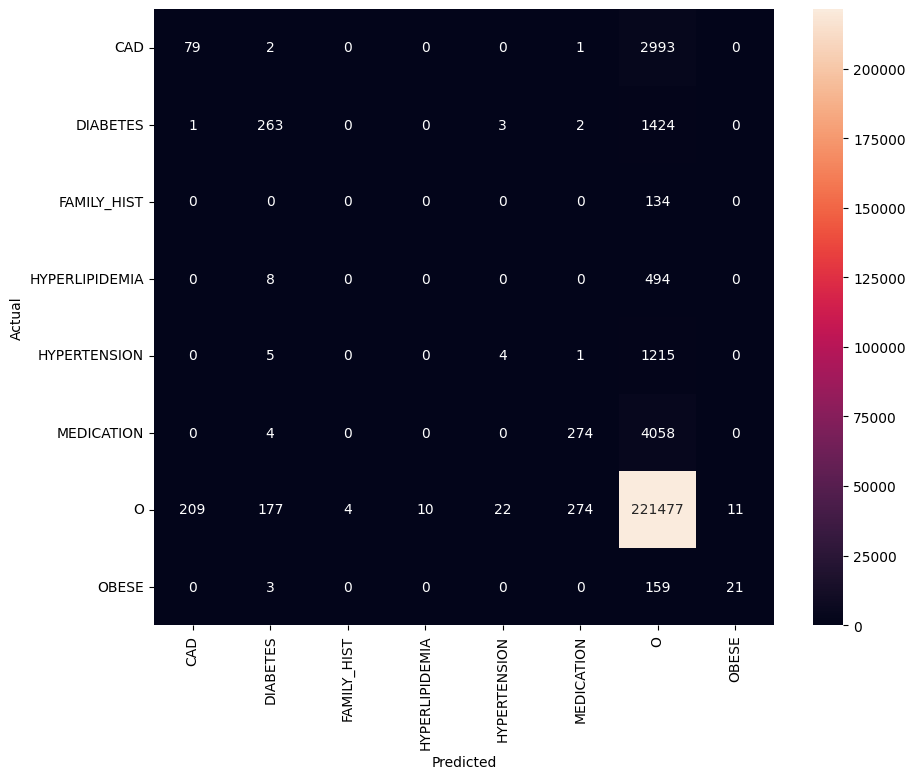

In [50]:
#Naive bayes
nb = MultinomialNB(alpha=.0005)
nb.partial_fit(x_train, y_train,classes=classes)

print (classification_report(y_pred=nb.predict(x_test), y_true=y_test, labels=new_classes))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

y_pred = nb.predict(x_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [51]:
'''
#decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

print (classification_report(y_pred=dt.predict(x_test), y_true=y_test, labels=new_classes))

y_pred = dt.predict(x_test)
'''

'\n#decision tree\nfrom sklearn.tree import DecisionTreeClassifier\ndt = DecisionTreeClassifier()\ndt.fit(x_train, y_train)\n\nprint (classification_report(y_pred=dt.predict(x_test), y_true=y_test, labels=new_classes))\n\ny_pred = dt.predict(x_test)\n'

## Prediction 

In [52]:
print(y_pred)

['O' 'O' 'O' ... 'O' 'O' 'O']


In [77]:
vadicationlist = testinglist.copy()
vadicationlist.insert(3, 'pred_label', '')

vadicationlist['pred_label'] = y_pred

vadicationlist.groupby('pred_label').count().sort_values(by='text',ascending=False)

,file,text,label
pred_label,,,
O,231954,231954,231954
MEDICATION,552,552,552
DIABETES,462,462,462
CAD,289,289,289
OBESE,32,32,32
HYPERTENSION,29,29,29
HYPERLIPIDEMIA,10,10,10
FAMILY_HIST,4,4,4


In [92]:
print(vadicationlist.groupby(['label']).count().sort_values(by='text',ascending=False).drop(['file','pred_label'],axis=1))
print(vadicationlist.groupby(['pred_label']).count().sort_values(by='text',ascending=False).drop(['file','label'],axis=1))

                  text
label                 
O               222184
MEDICATION        4336
CAD               3075
DIABETES          1693
HYPERTENSION      1225
HYPERLIPIDEMIA     502
OBESE              183
FAMILY_HIST        134
                  text
pred_label            
O               231954
MEDICATION         552
DIABETES           462
CAD                289
OBESE               32
HYPERTENSION        29
HYPERLIPIDEMIA      10
FAMILY_HIST          4


In [54]:
vadicationlist['file']-1

0        0
1        0
2        0
3        0
4        0
      ... 
619    513
620    513
621    513
622    513
623    513
Name: file, Length: 233332, dtype: object

In [55]:
#group the vadicationlist by file
vadicationlist_grouped = vadicationlist.groupby('file')
vadicationlist_grouped_list = []
for name,group in vadicationlist_grouped:
    vadicationlist_grouped_list.append(group)

print(vadicationlist_grouped_list[0])

#delete the 'file' column
for i in range(len(vadicationlist_grouped_list)):
    vadicationlist_grouped_list[i] = vadicationlist_grouped_list[i].drop(['file'],axis=1)


    file        text label pred_label
0      1      Record     O          O
1      1       date:     O          O
2      1  2069-04-07     O          O
3      1         Mr.     O          O
4      1    Villegas     O          O
..   ...         ...   ...        ...
160    1         not     O          O
161    1    reviewed     O          O
162    1   Attending     O          O
163    1    Provider     O          O
164    1    ********     O          O

[165 rows x 4 columns]


In [56]:
print(vadicationlist_grouped_list)

[           text label pred_label
0        Record     O          O
1         date:     O          O
2    2069-04-07     O          O
3           Mr.     O          O
4      Villegas     O          O
..          ...   ...        ...
160         not     O          O
161    reviewed     O          O
162   Attending     O          O
163    Provider     O          O
164    ********     O          O

[165 rows x 3 columns],                    text label pred_label
0                Record     O          O
1                 date:     O          O
2            2075-01-07     O          O
3                 NAME:     O          O
4             Villegas,     O          O
..                  ...   ...        ...
120             Gilbert     O          O
121                  P.     O          O
122              Perez,     O          O
123                M.D.     O          O
124  GPP/church/olinger     O          O

[125 rows x 3 columns],            text label pred_label
0        Record     O       

In [57]:
vadicationlist_grouped_list[0].shape

(165, 3)

In [58]:
Pred_text_tag = []
for i in range(len(vadicationlist_grouped_list)):
    Pred_text_tag_eachfile = []
    for j in range(len(vadicationlist_grouped_list[i])):
        Pred_text_tag_eachfile.append(vadicationlist_grouped_list[i]['text'][j]+' '+vadicationlist_grouped_list[i]['label'][j]+' '+vadicationlist_grouped_list[i]['pred_label'][j])
    Pred_text_tag.append(Pred_text_tag_eachfile)

In [59]:
print(len(Pred_text_tag[0]))
print(len(Pred_text_tag[1]))

165
125


In [60]:
corpus_test['Pred_text_tag'] = Pred_text_tag

In [61]:
corpus_test['Pred_text_tag'][0]

['Record O O',
 'date: O O',
 '2069-04-07 O O',
 'Mr. O O',
 'Villegas O O',
 'seen O O',
 'today. O O',
 'not O O',
 'seen O O',
 'since O O',
 'November. O O',
 'three O O',
 'weeks O O',
 'ago O O',
 'stopped O O',
 'Prednisone O O',
 'gaining O O',
 'weight. O O',
 'feel O O',
 'shoulders O O',
 'definitely O O',
 'improved. O O',
 'unclear O O',
 'actually O O',
 'taking, O O',
 'think O O',
 'based O O',
 'color O O',
 'pills O O',
 'timing O O',
 'medication O O',
 'continues O O',
 'taking MEDICATION O',
 'Atenolol HYPERTENSION O',
 'hypertension O O',
 '1 O O',
 'Hydroxychloroquine O O',
 'tablet. O O',
 'concerned O O',
 'relatively O O',
 'recent O O',
 'onset O O',
 'difficulties O O',
 'turning O O',
 'head O O',
 'right. O O',
 'this, O O',
 'note O O',
 'feels O O',
 'though O O',
 'going O O',
 'pass O O',
 'although O O',
 'not O O',
 'actually O O',
 'happened. O O',
 'occurs O O',
 'turns O O',
 'right O O',
 'not O O',
 'left. O O',
 'no O O',
 'visual O O',
 'chang

In [62]:
#save the corpus to a csv file
corpus_test.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus_test.csv',index=False,encoding='utf-8')

# Doc-level Prediction

In [63]:
Pred_doc_tag = []
#删除重复的tag
for i in range(len(vadicationlist_grouped_list)):
    Pred_doc_tag_eachfile = []
    for j in range(len(vadicationlist_grouped_list[i])):
        Pred_doc_tag_eachfile.append(vadicationlist_grouped_list[i]['pred_label'][j])
    Pred_doc_tag_eachfile = list(set(Pred_doc_tag_eachfile))
    Pred_doc_tag_eachfile.remove('O')
    Pred_doc_tag.append(Pred_doc_tag_eachfile)
#vadicationlist_grouped_list[0]['pred_label']

In [64]:
print(Pred_doc_tag[2])

['CAD', 'DIABETES', 'MEDICATION']


In [65]:
corpus_test['Pred_tag_doc'] = Pred_doc_tag

In [66]:
#save the corpus to a csv file
corpus_test.to_csv('E:/JHU/课程/datadesign/NLP/machine_learning/corpus_test.csv',index=False,encoding='utf-8')

# Evaluation

In [67]:
Evaluation = pd.DataFrame(columns=['file','Real_tag_doc','Pred_tag_doc'])
Evaluation['file'] = corpus_test.index
Evaluation['Real_tag_doc'] = corpus_test['Real_tag_doc']
Evaluation['Pred_tag_doc'] = Pred_doc_tag

Evaluation

,file,Real_tag_doc,Pred_tag_doc
0,0,"[HYPERTENSION, MEDICATION]",[]
1,1,[HYPERTENSION],[]
2,2,"[HYPERTENSION, OBESE, CAD, DIABETES, HYPERLIPI...","[CAD, DIABETES, MEDICATION]"
3,3,"[HYPERTENSION, OBESE, CAD, DIABETES, HYPERLIPI...",[DIABETES]
4,4,"[HYPERTENSION, DIABETES, MEDICATION]","[DIABETES, MEDICATION]"
...,...,...,...
509,509,"[HYPERTENSION, HYPERLIPIDEMIA, DIABETES, MEDIC...","[DIABETES, MEDICATION]"
510,510,[],[]
511,511,"[HYPERTENSION, DIABETES, MEDICATION]",[MEDICATION]
512,512,"[DIABETES, MEDICATION]",[MEDICATION]


In [68]:
Evaluation['Real_tag_doc'][0]

['HYPERTENSION', 'MEDICATION']

In [69]:
def evaluate_each(list, taget_tag):
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(list)):
        if taget_tag in list['Real_tag_doc'][i]:
            if taget_tag in list['Pred_tag_doc'][i]:
                TP += 1
            else:
                FN += 1
        else:
            if taget_tag in list['Pred_tag_doc'][i]:
                FP += 1

    #print('TP:',TP)
    #print('FP:',FP)
    #print('FN:',FN)
    return TP,FP,FN

def evaluate_matrix(list, taget_tag_list = ['SMOKER', 'FAMILY_HIST']):
    
    score_matrix = pd.DataFrame(columns=['target_tag','TP','FP','FN','precision','recall','F1','Support'])

    for taget_tag in taget_tag_list:
        TP,FP,FN = evaluate_each(list, taget_tag)
        if TP+FP == 0:
            if TP == 0:
                precision = 0
            else:
                precision = 1
        else:
            precision = TP/(TP+FP)
        if TP+FN == 0:
            if TP == 0:
                recall = 0
            else:
                recall = 1
        else:
            recall = TP/(TP+FN)
        if precision+recall == 0:
            if precision*recall == 0:
                F1 = 0
            else:
                F1 = 1
        else:
            F1 = 2*precision*recall/(precision+recall)
        
        score_matrix = score_matrix.append({'target_tag':taget_tag,'TP':TP,'FP':FP,'FN':FN,'precision':precision,'recall':recall,'F1':F1, 'Support':TP},ignore_index=True)
    
    support_sum = score_matrix['Support'].sum()
    support_proportion = score_matrix['Support']/support_sum
    
    weighted_precision = (score_matrix['precision']*support_proportion).sum()
    weighted_recall = (score_matrix['recall']*support_proportion).sum()
    weighted_F1 = (score_matrix['F1']*support_proportion).sum()

    
    score_matrix = score_matrix.append({'target_tag':'Total_macro','TP':score_matrix['TP'].sum(),'FP':score_matrix['FP'].sum(),'FN':score_matrix['FN'].sum(),'precision':score_matrix['precision'].mean(),'recall':score_matrix['recall'].mean(),'F1':score_matrix['F1'].mean(), 'Support':support_sum},ignore_index=True)
    score_matrix = score_matrix.append({'target_tag':'Total_micro','TP':score_matrix['TP'].sum(),'FP':score_matrix['FP'].sum(),'FN':score_matrix['FN'].sum(),'precision':score_matrix['TP'].sum()/(score_matrix['TP'].sum()+score_matrix['FP'].sum()),'recall':score_matrix['TP'].sum()/(score_matrix['TP'].sum()+score_matrix['FN'].sum()),'F1':2*score_matrix['TP'].sum()/(2*score_matrix['TP'].sum()+score_matrix['FP'].sum()+score_matrix['FN'].sum()), 'Support':support_sum},ignore_index=True)
    score_matrix = score_matrix.append({'target_tag':'Total_weighted','TP':score_matrix['TP'].sum(),'FP':score_matrix['FP'].sum(),'FN':score_matrix['FN'].sum(),'precision':weighted_precision,'recall':weighted_recall,'F1':weighted_F1, 'Support':support_sum},ignore_index=True)
    
    #print(score_matrix)
    return score_matrix



In [70]:
#Evaluate_Matrix = evaluate_matrix(Evaluation,taget_tag_list =['MEDICATION','CAD','DIABETES','SMOKER','HYPERTENSION','HYPERLIPIDEMIA','OBESE','FAMILY_HIST'])

#no smoker
Evaluate_Matrix = evaluate_matrix(Evaluation,taget_tag_list =['MEDICATION','CAD','DIABETES','HYPERTENSION','HYPERLIPIDEMIA','OBESE','FAMILY_HIST'])

C:\Users\52594\AppData\Local\Temp\ipykernel_29364\616768366.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_matrix = score_matrix.append({'target_tag':taget_tag,'TP':TP,'FP':FP,'FN':FN,'precision':precision,'recall':recall,'F1':F1, 'Support':TP},ignore_index=True)
C:\Users\52594\AppData\Local\Temp\ipykernel_29364\616768366.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_matrix = score_matrix.append({'target_tag':taget_tag,'TP':TP,'FP':FP,'FN':FN,'precision':precision,'recall':recall,'F1':F1, 'Support':TP},ignore_index=True)
C:\Users\52594\AppData\Local\Temp\ipykernel_29364\616768366.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_matrix = score_matrix.append({'target_tag':taget_tag,'TP':TP,'

In [71]:
print(Evaluate_Matrix)

       target_tag    TP   FP    FN  precision    recall        F1 Support
0      MEDICATION   256    3   195   0.988417  0.567627  0.721127     256
1             CAD    88   30   138   0.745763  0.389381  0.511628      88
2        DIABETES   219   26   145   0.893878  0.601648  0.719212     219
3    HYPERTENSION    18    7   375   0.720000  0.045802  0.086124      18
4  HYPERLIPIDEMIA     6    3   243   0.666667  0.024096  0.046512       6
5           OBESE    20    6    67   0.769231  0.229885  0.353982      20
6     FAMILY_HIST     1    3    18   0.250000  0.052632  0.086957       1
7     Total_macro   608   78  1181   0.719136  0.273010  0.360792     608
8     Total_micro  1216  156  2362   0.886297  0.339855  0.491313     608
9  Total_weighted  2432  312  4724   0.899697  0.521313  0.651538     608
